In [ ]:
!pip install hdbscan
!pip install geopandas
!pip install movingpandas

In [ ]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import complete, fcluster, single, ward, average
from scipy.spatial.distance import pdist
from datetime import datetime
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

import warnings
warnings.filterwarnings('ignore')

opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()

In [ ]:
df = pd.read_csv("/content/centres.csv", header = None)
df[3] = [datetime.fromtimestamp(x) for x in df[3]]

In [ ]:
df.columns = ["x", "y", "depth", "timestamp"]

In [ ]:
df_clustering = df.drop("timestamp", axis = 1)

In [ ]:
fig = px.scatter_3d(df_clustering, x='x', y='y', z='depth')
fig.show()

In [ ]:
y = pdist(df_clustering)
Z = single(y)
df_clustering["labels"] = fcluster(Z, 50, criterion='distance')
fig = px.scatter_3d(df_clustering, x='x', y='y', z='depth', color = "labels")
fig.show()

In [ ]:
# Level wise data points 

df_sub = df_clustering[df_clustering["labels"] == 4].reset_index()
#df_sub = df_clustering.reset_index()
df_sub.drop(["labels"], inplace=True, axis=1)

In [ ]:
# Scaling

# scaler = MinMaxScaler()
# df_sub = scaler.fit_transform(df_sub.to_numpy())
# df_sub = pd.DataFrame(df_sub, columns=['index', 'x', 'y', 'depth'])

In [ ]:
# Level wise clustering

y = pdist(df_sub)
Z = single(y)
df_sub["labels"] = fcluster(Z, 47, criterion='distance')
fig = px.scatter_3d(df_sub, x='x', y='y', z='depth', color = "labels")
fig.show()

In [ ]:
# Plotting tragectories
# Considering a trajectory only if it has 5 or more points

df_sub["timestamp"] = df["timestamp"].iloc[df_sub["index"]].reset_index(drop=True)
df_sub['geometry'] = [Point(xy) for xy in zip(df_sub.x, df_sub.y)] 
df_sub = df_sub.groupby('labels').filter(lambda x : len(x)>5).reset_index(drop=True)
geometry = [Point(xy) for xy in zip(df_sub.x, df_sub.y)]
gdf = GeoDataFrame(df_sub, crs="EPSG:4326", geometry=geometry)
traj_collection = mpd.TrajectoryCollection(gdf, 'labels', t='timestamp')
print(traj_collection)

TrajectoryCollection with 6 trajectories


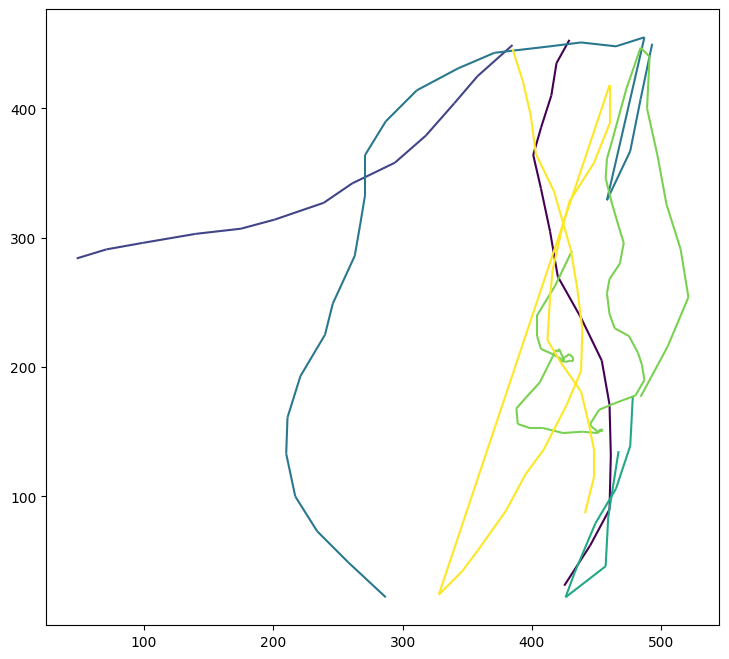

In [ ]:
traj_collection.plot(column='labels', figsize=(14,8), aspect=1)

In [ ]:
# Start locations of all trajectories

traj_collection.get_start_locations()

,index,x,y,depth,labels,geometry
2021-04-30 15:36:23.256129,190.0,425.0,31.0,782.0,2.0,POINT (425.000 31.000)
2021-04-30 15:36:29.542980,238.0,385.0,449.0,849.0,3.0,POINT (385.000 449.000)
2021-04-30 15:36:15.356906,78.0,493.0,450.0,856.0,4.0,POINT (493.000 450.000)
2021-04-30 15:36:27.128255,230.0,467.0,135.0,820.0,5.0,POINT (467.000 135.000)
2021-04-30 15:36:15.846783,85.0,431.0,290.0,833.0,6.0,POINT (431.000 290.000)
2021-04-30 15:36:09.293875,2.0,441.0,87.0,782.0,7.0,POINT (441.000 87.000)


In [ ]:
# Experiment with HDBSCAN clustering
# Many noise points

clusterer = hdbscan.HDBSCAN(min_cluster_size=40, cluster_selection_epsilon=0).fit(df_clustering)
df_clustering["labels"] = clusterer.labels_
fig = px.scatter_3d(df_clustering, x='x', y='y', z='depth', color = "labels")
fig.show()